In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
#from torch.utils.tensorboard import SummaryWriter
import torchvision
from torchvision import datasets
from torchvision import transforms
import numpy as np
import os

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

results_dir = os.path.join("..","results","wavelet_learning")

img_size = 32 #resize the MNIST images to this dimension 

#dataloader
from torch.utils.data import DataLoader
batch_size = 32

#dataloading
transform_train = transforms.Compose(
    [#transforms.RandomHorizontalFlip(),
     transforms.Resize((img_size, img_size)),
     transforms.ToTensor(),
     ])

dataset = datasets.FashionMNIST(root='../data/FashionMNIST', train=True, transform=transform_train, download=True)
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
print('# training minibatches = %d'%len(train_loader))

cpu
# training minibatches = 1875


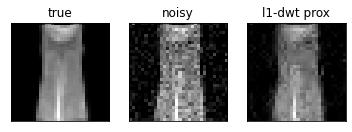

In [9]:
import matplotlib.pyplot as plt
from proxes.l1_dwt import prox_l1_dwt

#add noise, denoise using a prox. operator
noise_sd = 0.10
alpha = 0.10 * noise_sd**2  # regularization parameter
lambd = 1/noise_sd**2  # step size in MUYLA
lambda_reg = alpha * lambd

for idx, (images, labels) in enumerate(train_loader):
  x_true = images.to(device) #true images
  x_noisy = x_true + noise_sd*torch.randn(x_true.size()).to(device)
  #see true, noisy, and denoised
  x_true_im = x_true[0,:,:].cpu().detach().numpy().squeeze()
  x_noisy_im = x_noisy[0,:,:].cpu().detach().numpy().squeeze()
  x_dwt_im = prox_l1_dwt(lambda_reg, x_noisy_im,level=2)

  plt.subplot(131)
  vmin, vmax = x_true_im.min(), x_true_im.max()
  plt.imshow(x_true_im,cmap='gray',vmin=vmin, vmax=vmax)
  plt.xticks([])
  plt.yticks([])
  plt.title('true')

  plt.subplot(132)
  plt.imshow(x_noisy_im,cmap='gray',vmin=vmin, vmax=vmax)
  plt.xticks([])
  plt.yticks([])
  plt.title('noisy')

  plt.subplot(133)
  plt.imshow(x_dwt_im,cmap='gray',vmin=vmin, vmax=vmax)
  plt.xticks([])
  plt.yticks([])
  plt.title('l1-dwt prox')

  plt.gcf().set_size_inches(6.0, 4.0)

  break

In [10]:
#unrolled gradient network
n_filters = 16
n_in_channels = 1
tau = 0.01*torch.ones(1).to(device)

class cnn_image_space(nn.Module):
    def __init__(self, n_in_channels=2, n_out_channels = 1, n_filters=n_filters): #2 input channels, 1 for image, 1 for noisy data
        super(cnn_image_space, self).__init__()
        
        self.conv1 = nn.Conv2d(n_in_channels, out_channels=n_filters, kernel_size=3, stride=1, padding=1, bias=True)
        self.conv2 = nn.Conv2d(n_filters, n_filters, kernel_size=3, stride=1, padding=1, bias=True)
        self.conv3 = nn.Conv2d(n_filters, out_channels=1, kernel_size=3, stride=1, padding=1, bias=True)
        
        self.act1 = nn.PReLU(num_parameters=1, init=0.25)
        self.act2 = nn.PReLU(num_parameters=1, init=0.25)
        
    def forward(self, x, u):
        dx = torch.cat((x, u), dim=1)
        dx = self.act1(self.conv1(dx))
        dx = self.act2(self.conv2(dx))
        dx = self.conv3(dx)
        return dx
    
class unrolled_gradient_model(nn.Module):
    def __init__(self, niter=5, tau=tau): #niter=10 worked quite well
        super(unrolled_gradient_model, self).__init__()
        
        self.niter = niter
        self.tau = nn.Parameter(tau * torch.ones(self.niter).to(device))
        self.cnn_image_layers = nn.ModuleList([cnn_image_space().to(device) for i in range(self.niter)])
        
    def forward(self, y): #y = noisy data
        x = y
        for iteration in range(self.niter):
            x = x - self.tau[iteration] * self.cnn_image_layers[iteration](x, y) # x = x - step_size*dx
        return x

net = unrolled_gradient_model().to(device)

In [11]:
from pytorch_wavelets import DWTForward
def wavelet_l1_penalty(network_output):
    J = 2
    xfm = DWTForward(J=J, wave='db4', mode='zero').to(device)  # We can use up to level J=2 for bd4 wavelets
    Yl, Yh = xfm(network_output)
    penalty = torch.sum(torch.abs(Yl))
    for i in range(J):
        penalty += torch.sum(torch.abs(Yh[i]))
        
    return penalty

epoch[1/10] mini-batch[200/1875] avg_prox_loss 610.211913:


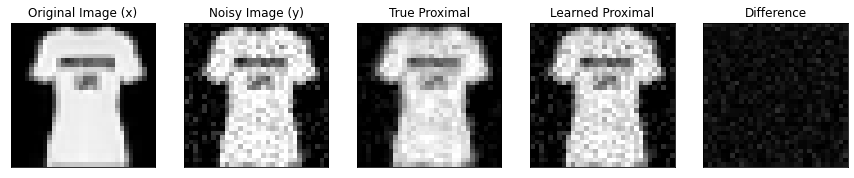

epoch[1/10] mini-batch[400/1875] avg_prox_loss 555.525488:


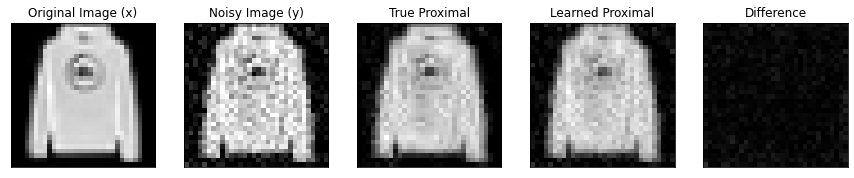

epoch[1/10] mini-batch[600/1875] avg_prox_loss 524.474820:


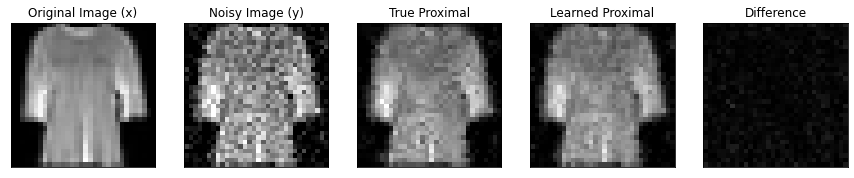

epoch[1/10] mini-batch[800/1875] avg_prox_loss 520.072860:


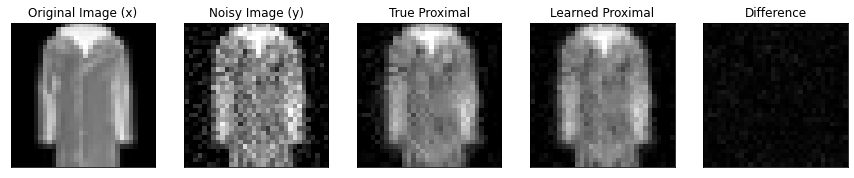

epoch[1/10] mini-batch[1000/1875] avg_prox_loss 519.565965:


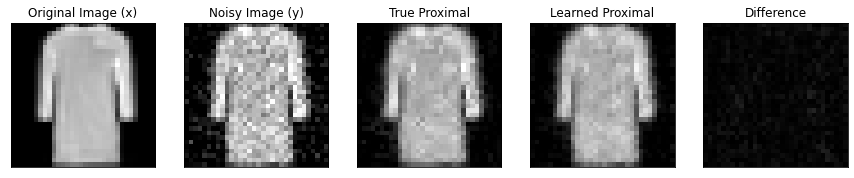

epoch[1/10] mini-batch[1200/1875] avg_prox_loss 514.416530:


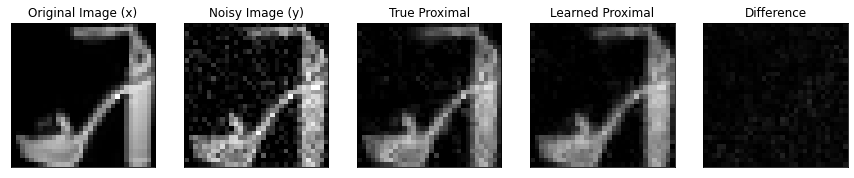

epoch[1/10] mini-batch[1400/1875] avg_prox_loss 517.586178:


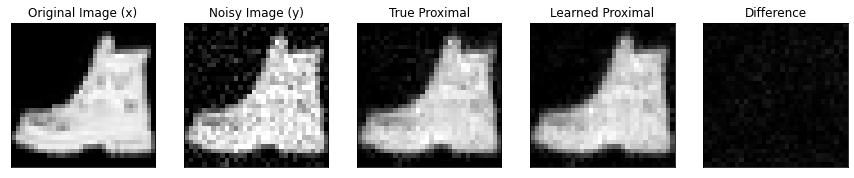

epoch[1/10] mini-batch[1600/1875] avg_prox_loss 515.399073:


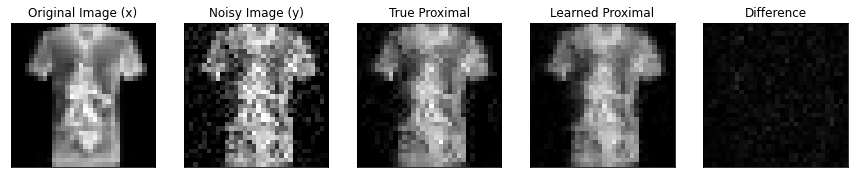

epoch[1/10] mini-batch[1800/1875] avg_prox_loss 511.965507:


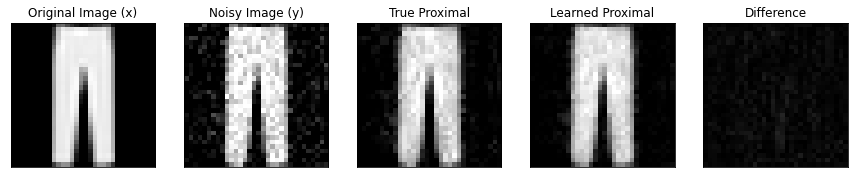

epoch[2/10] mini-batch[200/1875] avg_prox_loss 512.751763:


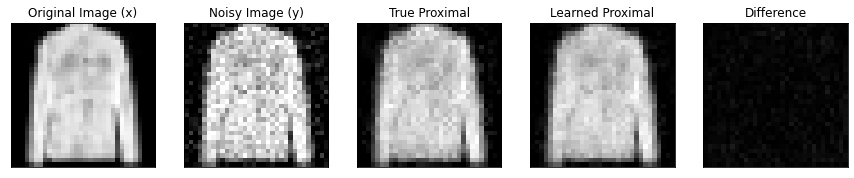

epoch[2/10] mini-batch[400/1875] avg_prox_loss 509.123878:


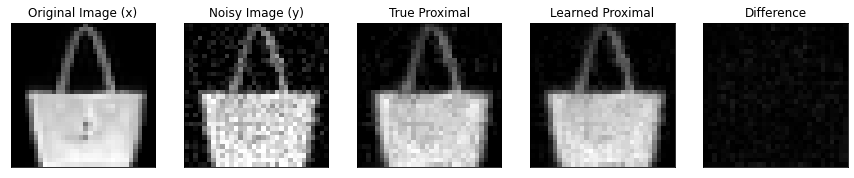

epoch[2/10] mini-batch[600/1875] avg_prox_loss 507.704863:


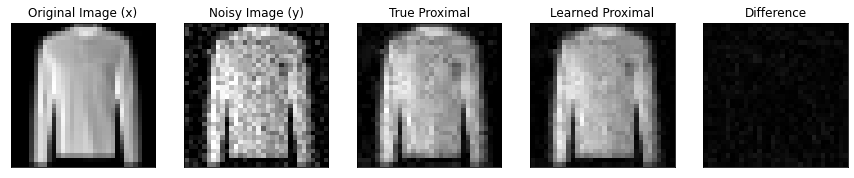

epoch[2/10] mini-batch[800/1875] avg_prox_loss 509.013798:


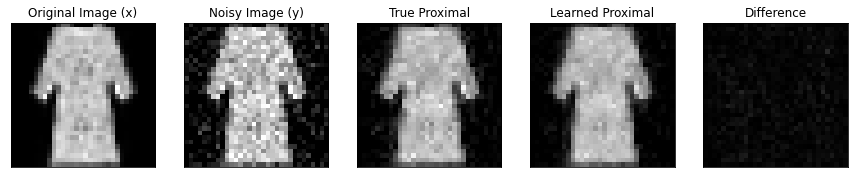

epoch[2/10] mini-batch[1000/1875] avg_prox_loss 507.109960:


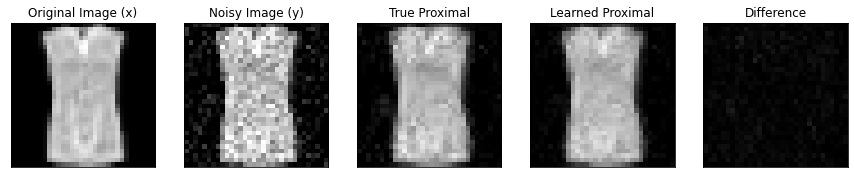

epoch[2/10] mini-batch[1200/1875] avg_prox_loss 506.428917:


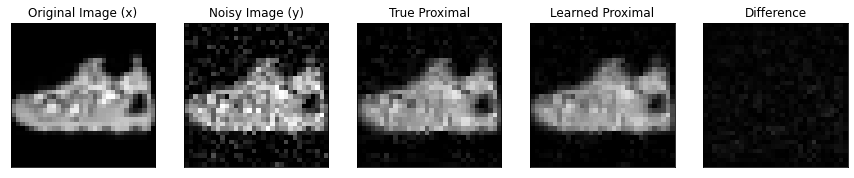

epoch[2/10] mini-batch[1400/1875] avg_prox_loss 506.294256:


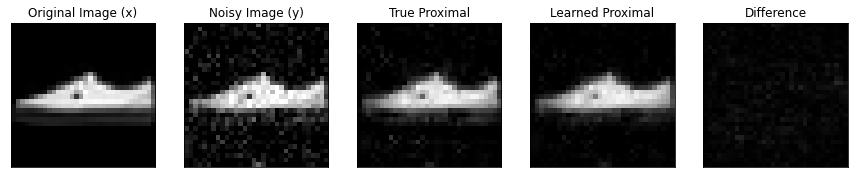

epoch[2/10] mini-batch[1600/1875] avg_prox_loss 505.294951:


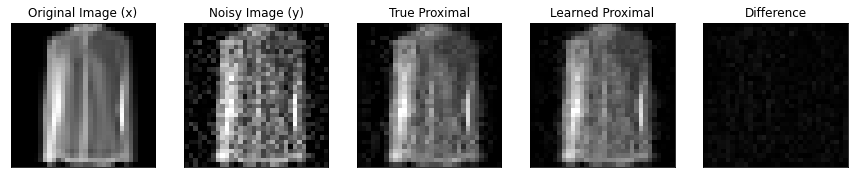

epoch[2/10] mini-batch[1800/1875] avg_prox_loss 508.481715:


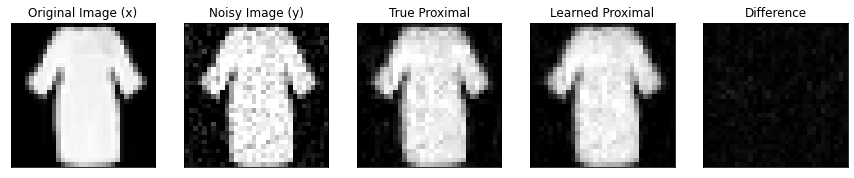

epoch[3/10] mini-batch[200/1875] avg_prox_loss 507.487183:


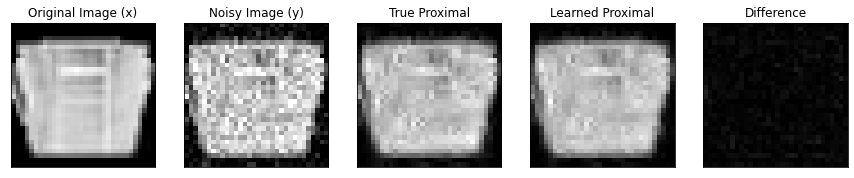

epoch[3/10] mini-batch[400/1875] avg_prox_loss 507.306085:


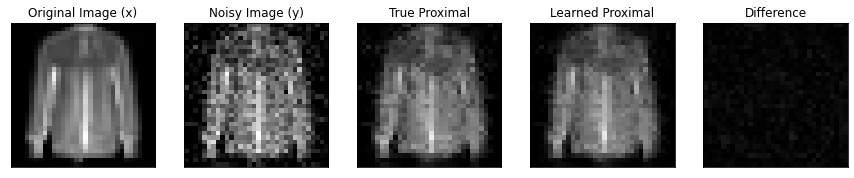

epoch[3/10] mini-batch[600/1875] avg_prox_loss 505.317609:


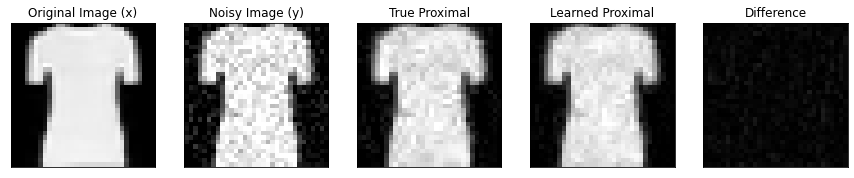

epoch[3/10] mini-batch[800/1875] avg_prox_loss 506.806642:


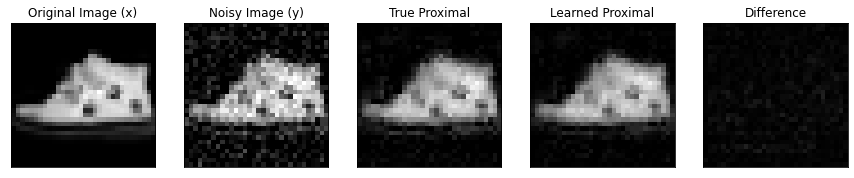

epoch[3/10] mini-batch[1000/1875] avg_prox_loss 506.163334:


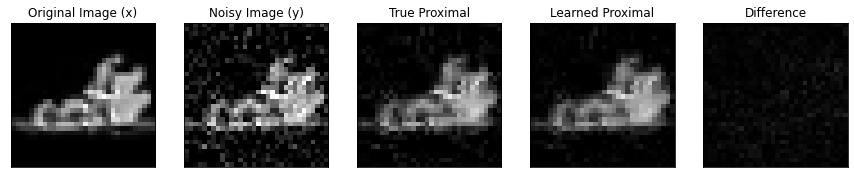

epoch[3/10] mini-batch[1200/1875] avg_prox_loss 507.611710:


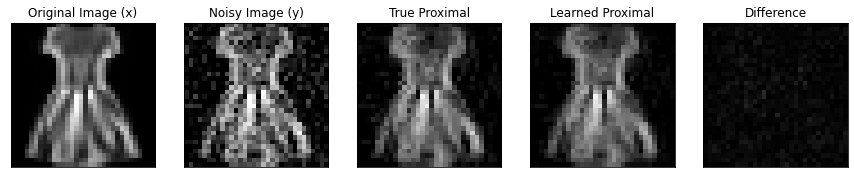

epoch[3/10] mini-batch[1400/1875] avg_prox_loss 504.816566:


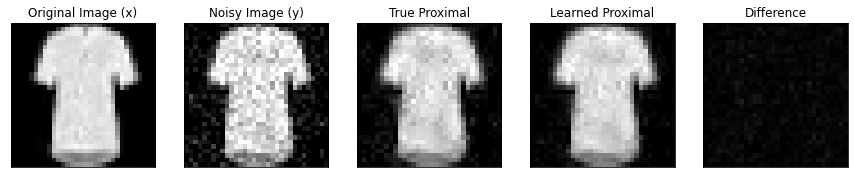

epoch[3/10] mini-batch[1600/1875] avg_prox_loss 506.748318:


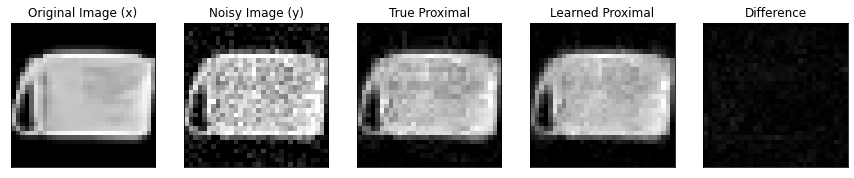

epoch[3/10] mini-batch[1800/1875] avg_prox_loss 506.246335:


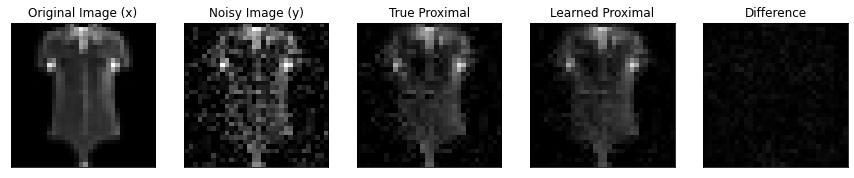

epoch[4/10] mini-batch[200/1875] avg_prox_loss 507.364460:


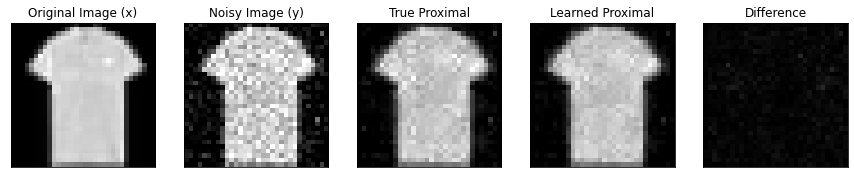

epoch[4/10] mini-batch[400/1875] avg_prox_loss 504.301767:


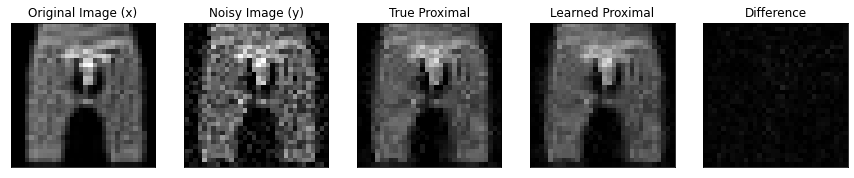

epoch[4/10] mini-batch[600/1875] avg_prox_loss 507.098169:


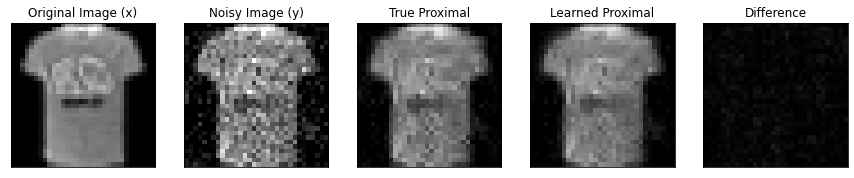

epoch[4/10] mini-batch[800/1875] avg_prox_loss 506.557858:


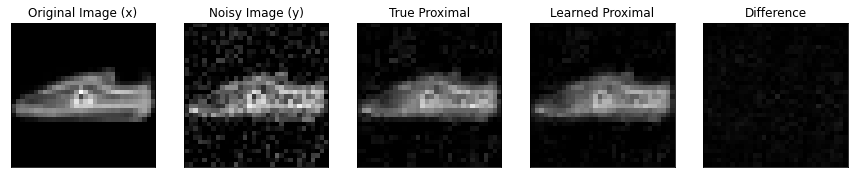

epoch[4/10] mini-batch[1000/1875] avg_prox_loss 506.052269:


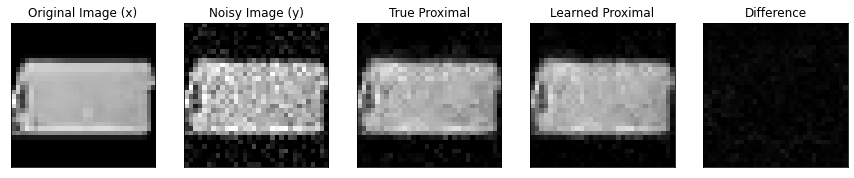

epoch[4/10] mini-batch[1200/1875] avg_prox_loss 503.067490:


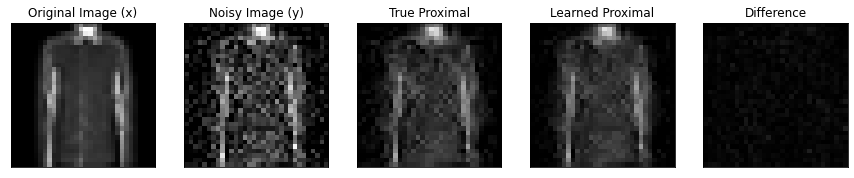

epoch[4/10] mini-batch[1400/1875] avg_prox_loss 506.781659:


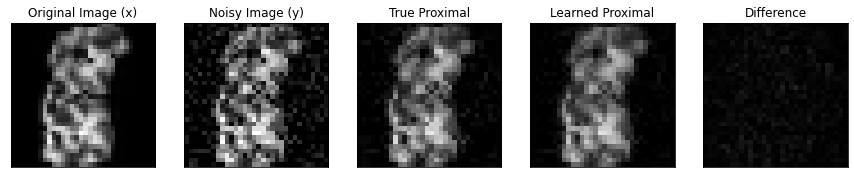

epoch[4/10] mini-batch[1600/1875] avg_prox_loss 507.100300:


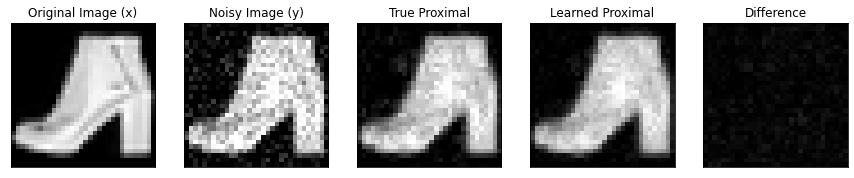

epoch[4/10] mini-batch[1800/1875] avg_prox_loss 503.272881:


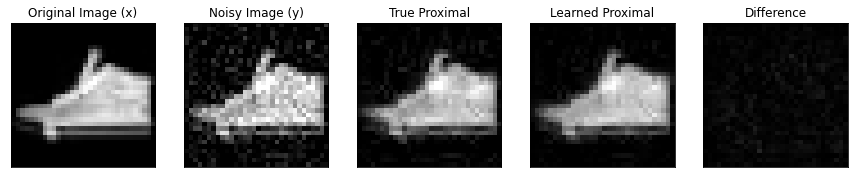

epoch[5/10] mini-batch[200/1875] avg_prox_loss 507.279047:


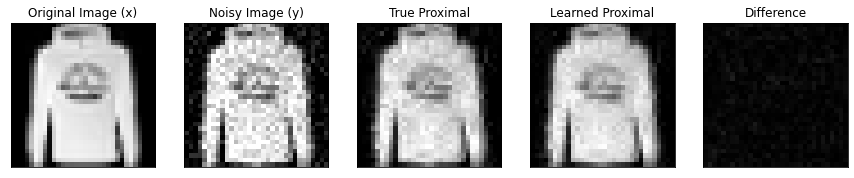

epoch[5/10] mini-batch[400/1875] avg_prox_loss 504.689440:


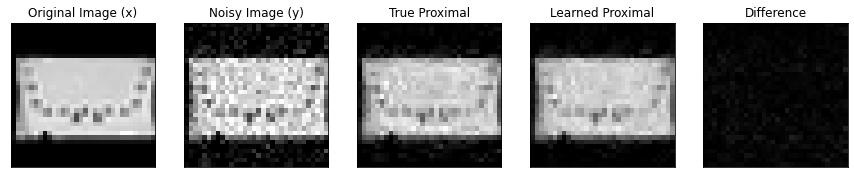

epoch[5/10] mini-batch[600/1875] avg_prox_loss 508.652980:


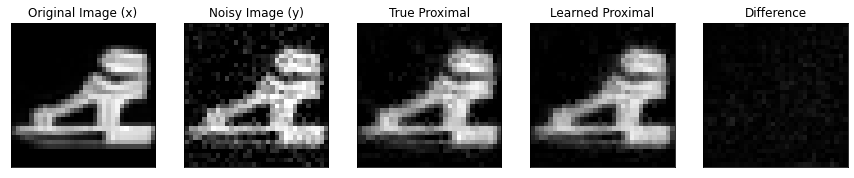

epoch[5/10] mini-batch[800/1875] avg_prox_loss 504.964002:


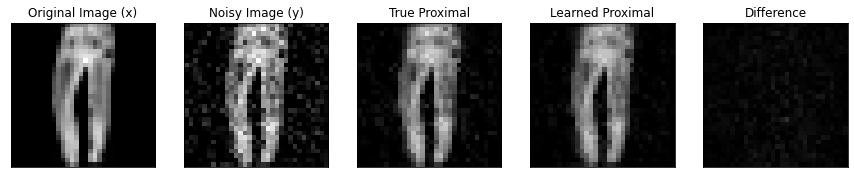

epoch[5/10] mini-batch[1000/1875] avg_prox_loss 502.593696:


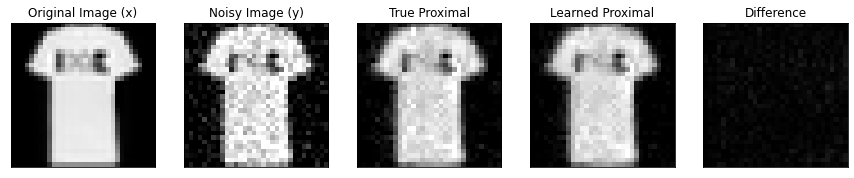

epoch[5/10] mini-batch[1200/1875] avg_prox_loss 505.551798:


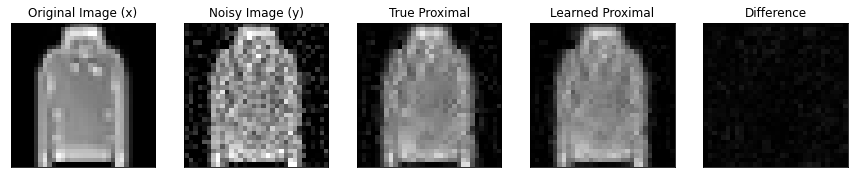

epoch[5/10] mini-batch[1400/1875] avg_prox_loss 504.025831:


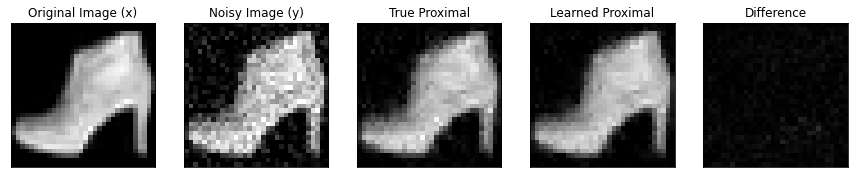

epoch[5/10] mini-batch[1600/1875] avg_prox_loss 506.217625:


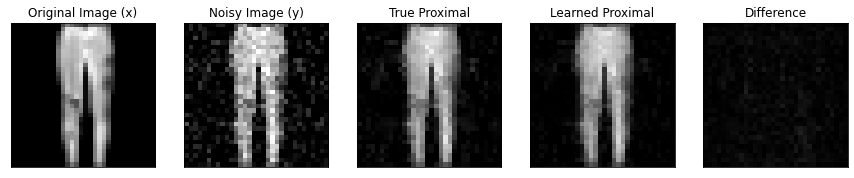

epoch[5/10] mini-batch[1800/1875] avg_prox_loss 503.982200:


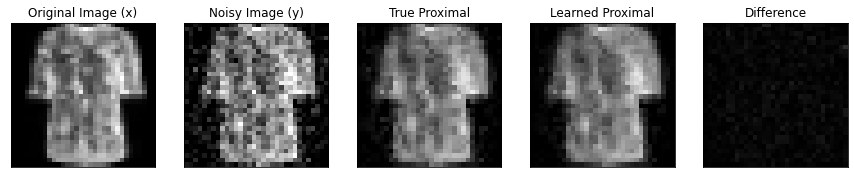

epoch[6/10] mini-batch[200/1875] avg_prox_loss 506.998284:


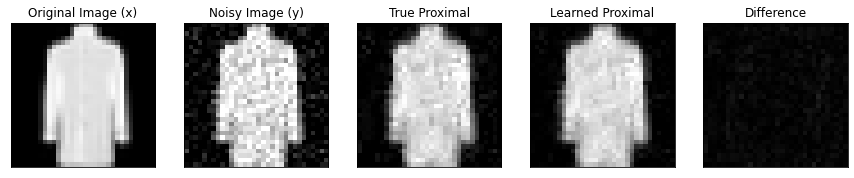

epoch[6/10] mini-batch[400/1875] avg_prox_loss 504.101269:


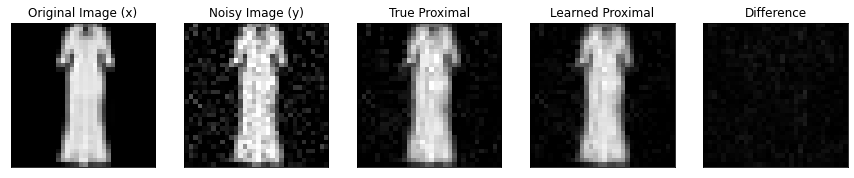

epoch[6/10] mini-batch[600/1875] avg_prox_loss 504.878820:


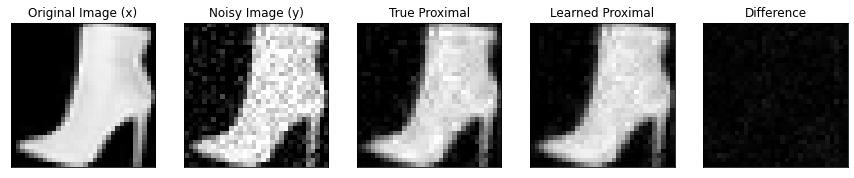

epoch[6/10] mini-batch[800/1875] avg_prox_loss 505.869141:


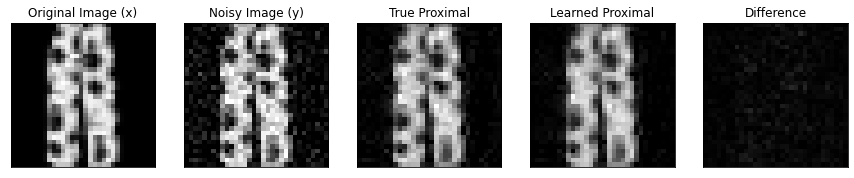

epoch[6/10] mini-batch[1000/1875] avg_prox_loss 504.584200:


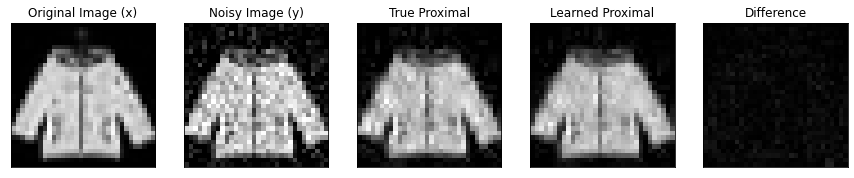

epoch[6/10] mini-batch[1200/1875] avg_prox_loss 504.770868:


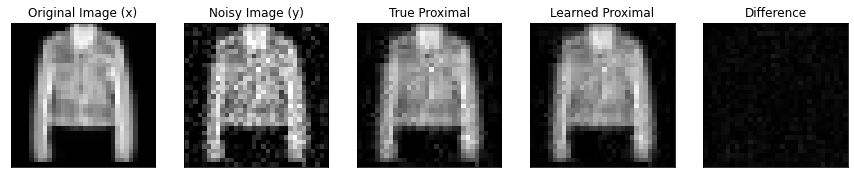

epoch[6/10] mini-batch[1400/1875] avg_prox_loss 505.497525:


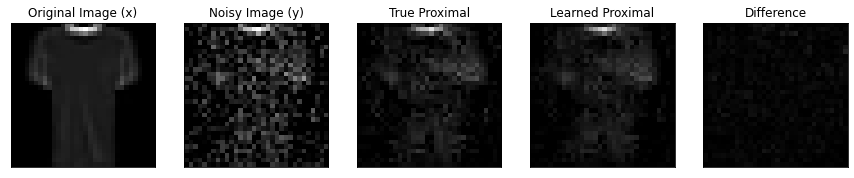

epoch[6/10] mini-batch[1600/1875] avg_prox_loss 502.719113:


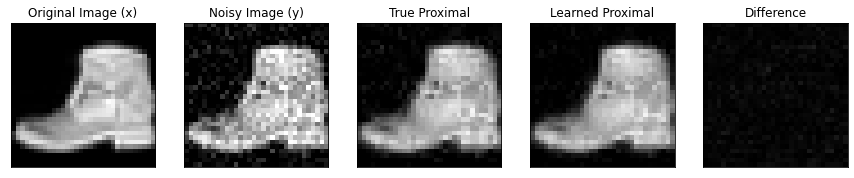

epoch[6/10] mini-batch[1800/1875] avg_prox_loss 505.732744:


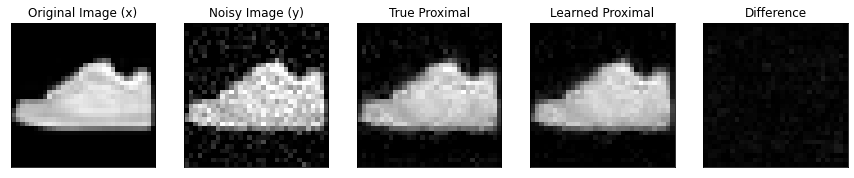

epoch[7/10] mini-batch[200/1875] avg_prox_loss 502.461852:


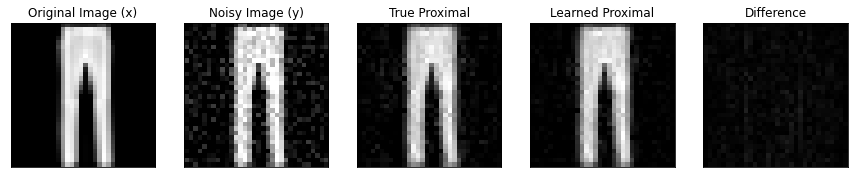

epoch[7/10] mini-batch[400/1875] avg_prox_loss 506.747691:


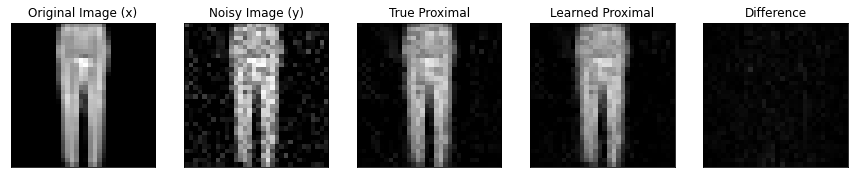

epoch[7/10] mini-batch[600/1875] avg_prox_loss 502.909359:


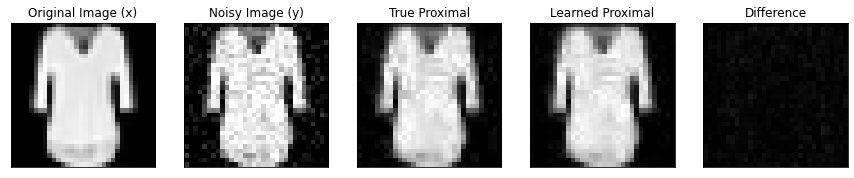

epoch[7/10] mini-batch[800/1875] avg_prox_loss 505.172178:


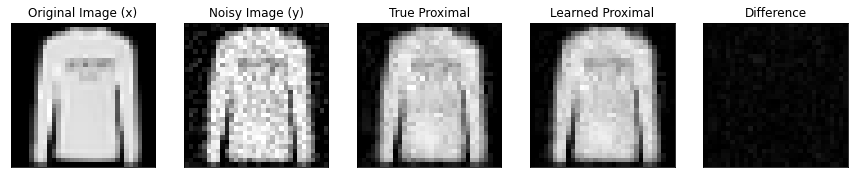

epoch[7/10] mini-batch[1000/1875] avg_prox_loss 503.921052:


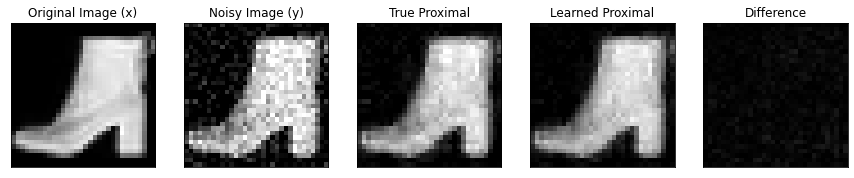

epoch[7/10] mini-batch[1200/1875] avg_prox_loss 506.522657:


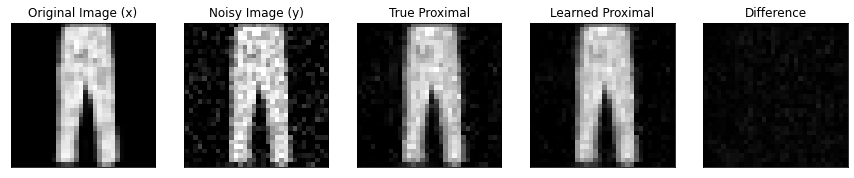

epoch[7/10] mini-batch[1400/1875] avg_prox_loss 504.875470:


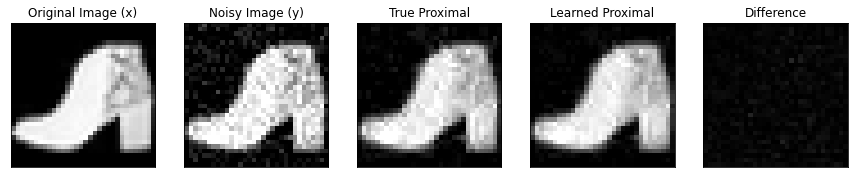

epoch[7/10] mini-batch[1600/1875] avg_prox_loss 506.002003:


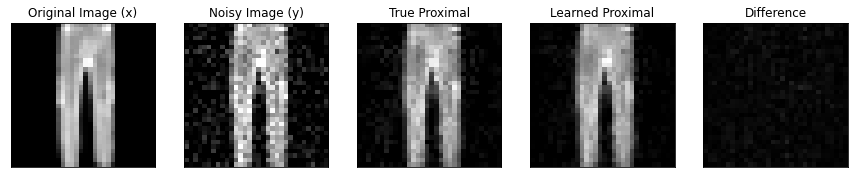

epoch[7/10] mini-batch[1800/1875] avg_prox_loss 504.345862:


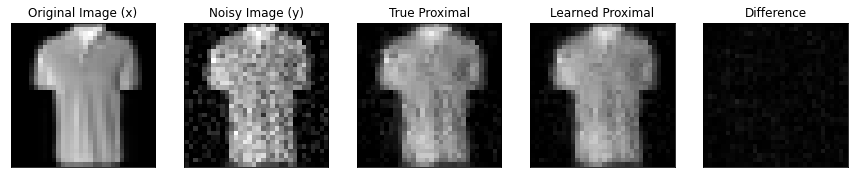

epoch[8/10] mini-batch[200/1875] avg_prox_loss 503.868359:


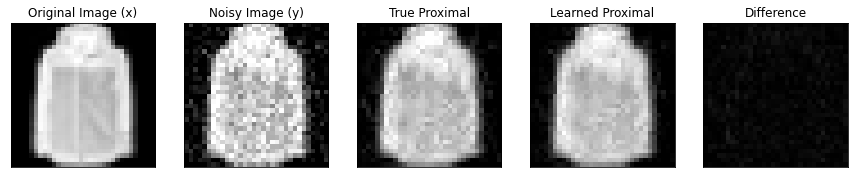

epoch[8/10] mini-batch[400/1875] avg_prox_loss 502.346131:


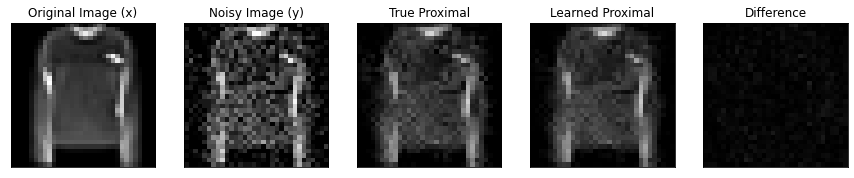

epoch[8/10] mini-batch[600/1875] avg_prox_loss 501.981103:


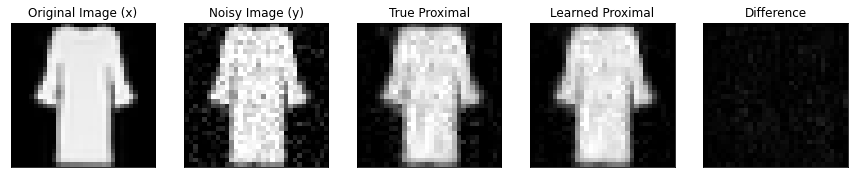

epoch[8/10] mini-batch[800/1875] avg_prox_loss 504.849494:


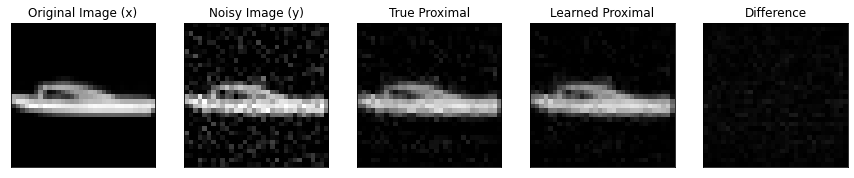

epoch[8/10] mini-batch[1000/1875] avg_prox_loss 503.017984:


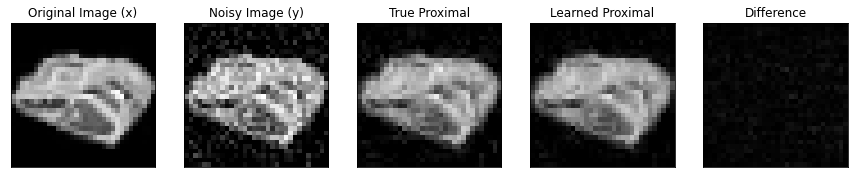

epoch[8/10] mini-batch[1200/1875] avg_prox_loss 505.660424:


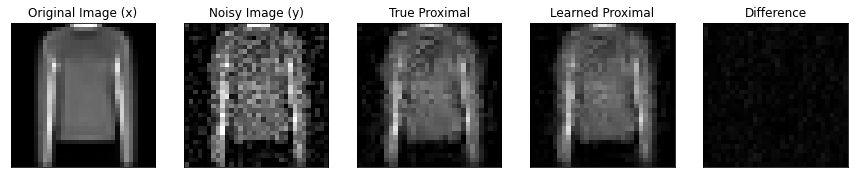

epoch[8/10] mini-batch[1400/1875] avg_prox_loss 504.418825:


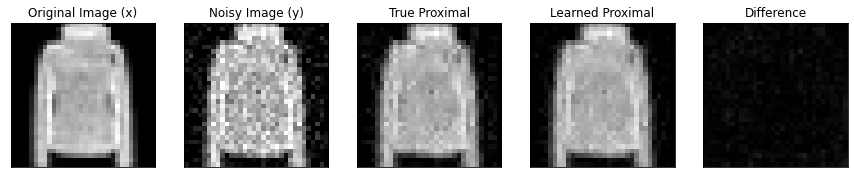

epoch[8/10] mini-batch[1600/1875] avg_prox_loss 506.348038:


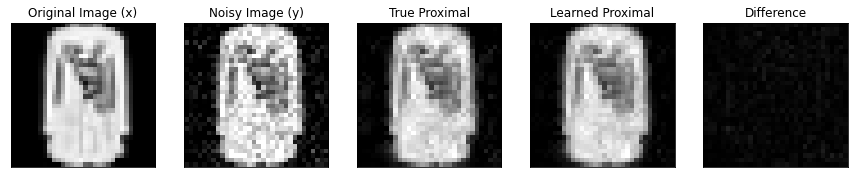

epoch[8/10] mini-batch[1800/1875] avg_prox_loss 507.314142:


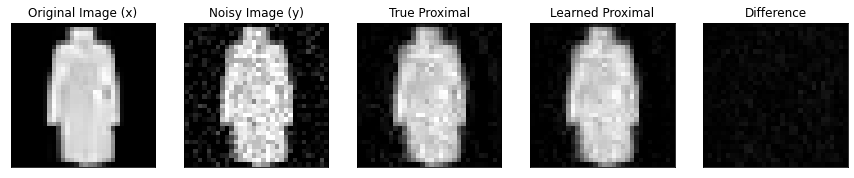

epoch[9/10] mini-batch[200/1875] avg_prox_loss 501.243617:


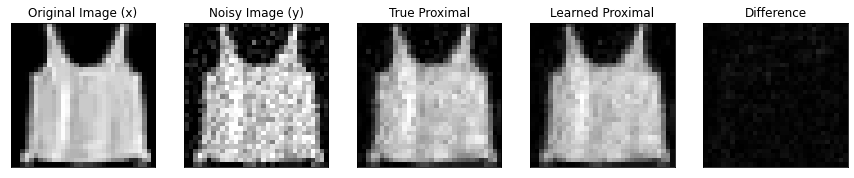

epoch[9/10] mini-batch[400/1875] avg_prox_loss 504.553981:


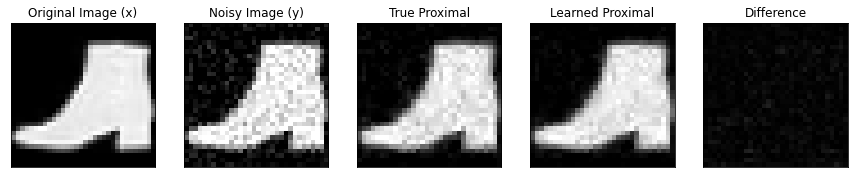

epoch[9/10] mini-batch[600/1875] avg_prox_loss 505.151729:


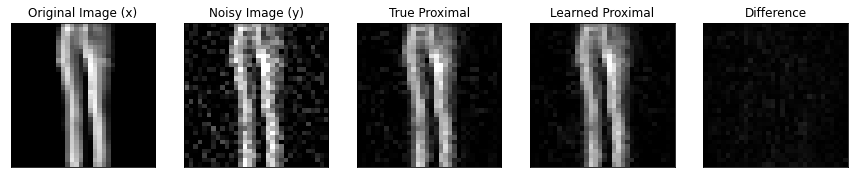

epoch[9/10] mini-batch[800/1875] avg_prox_loss 506.086585:


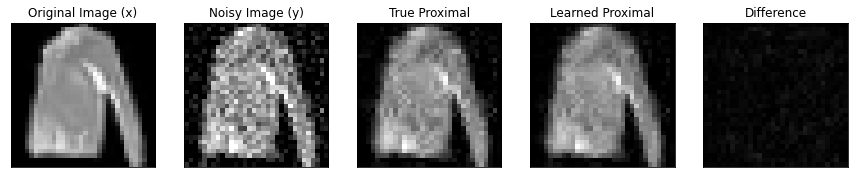

epoch[9/10] mini-batch[1000/1875] avg_prox_loss 505.204649:


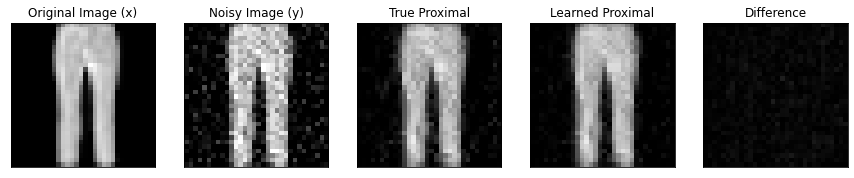

epoch[9/10] mini-batch[1200/1875] avg_prox_loss 503.915037:


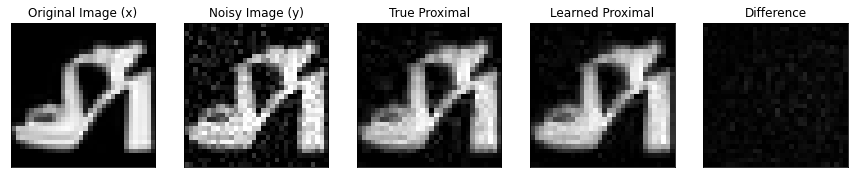

epoch[9/10] mini-batch[1400/1875] avg_prox_loss 503.856653:


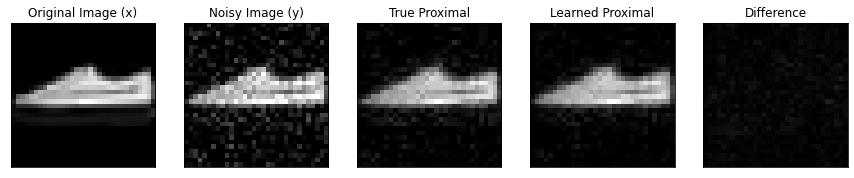

epoch[9/10] mini-batch[1600/1875] avg_prox_loss 504.677164:


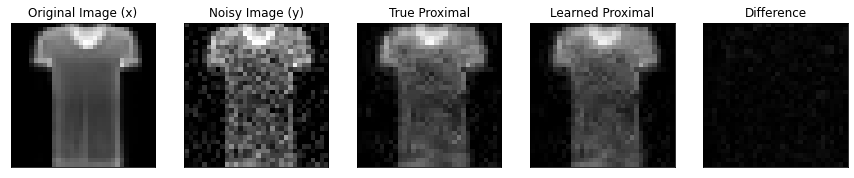

epoch[9/10] mini-batch[1800/1875] avg_prox_loss 504.862858:


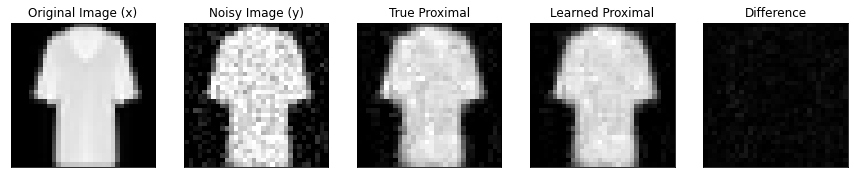

epoch[10/10] mini-batch[200/1875] avg_prox_loss 505.194298:


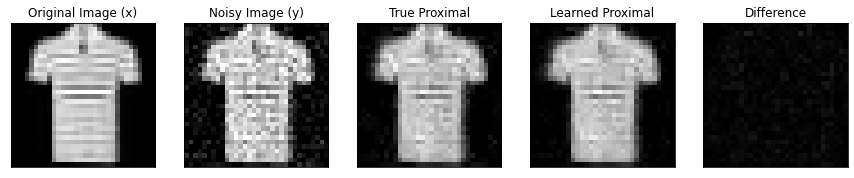

epoch[10/10] mini-batch[400/1875] avg_prox_loss 504.297484:


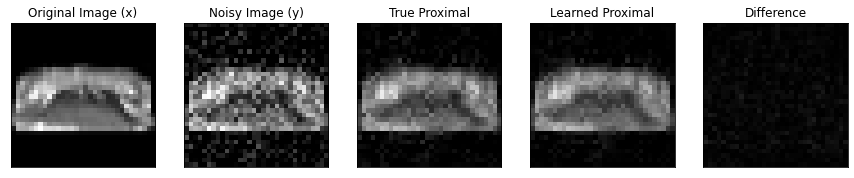

epoch[10/10] mini-batch[600/1875] avg_prox_loss 500.224343:


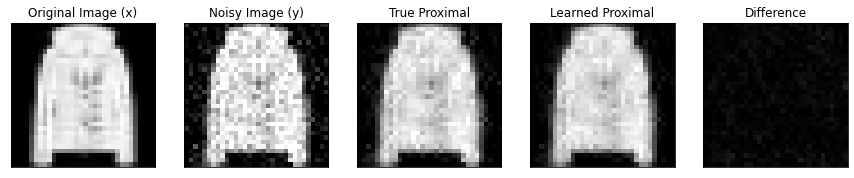

epoch[10/10] mini-batch[800/1875] avg_prox_loss 501.447705:


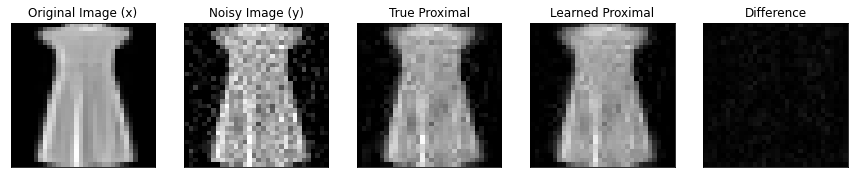

epoch[10/10] mini-batch[1000/1875] avg_prox_loss 506.581449:


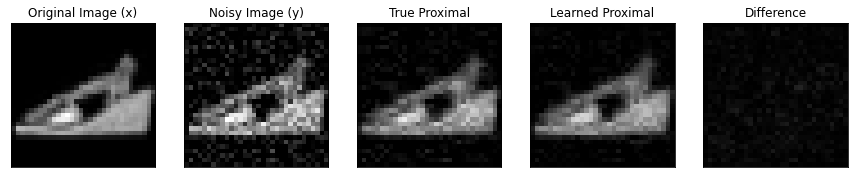

epoch[10/10] mini-batch[1200/1875] avg_prox_loss 503.354525:


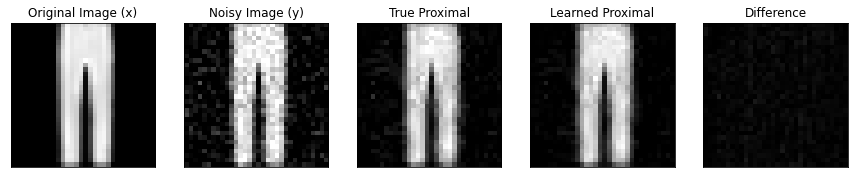

epoch[10/10] mini-batch[1400/1875] avg_prox_loss 505.562568:


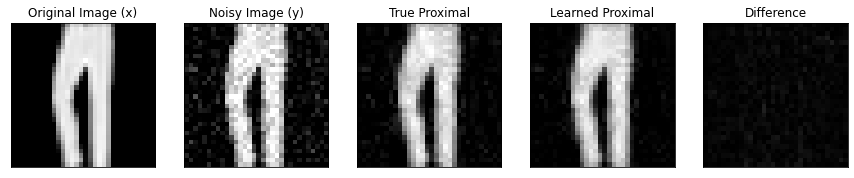

epoch[10/10] mini-batch[1600/1875] avg_prox_loss 502.847286:


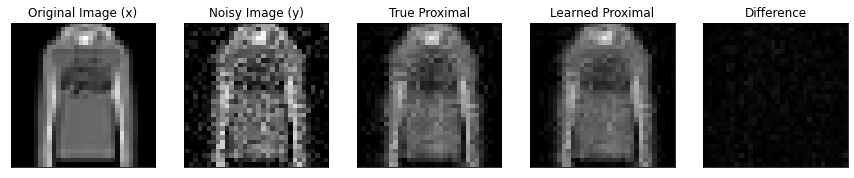

epoch[10/10] mini-batch[1800/1875] avg_prox_loss 506.634886:


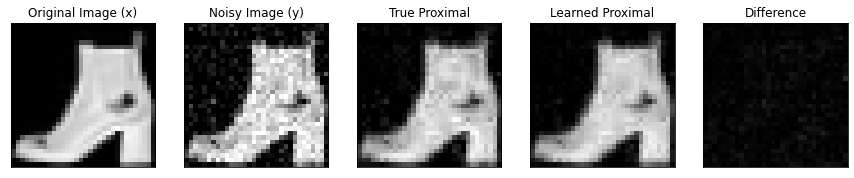

In [12]:
optimizer = torch.optim.Adam(net.parameters(), lr=1e-4, betas=(0.9,0.99))

#main training loop
n_epochs = 10
num_minibatches = 200 #display the loss after these many mini-batches


for epoch in np.arange(n_epochs):
    total_prox_loss = 0.0
    save_im = True
      
    for idx, (images, labels) in enumerate(train_loader):
        x_true = images.to(device) #true images
        x_noisy = x_true + noise_sd*torch.randn(x_true.size()).to(device)
        
        #optimize the net
        network_output = net(x_noisy)
        wavelet_penalty = wavelet_l1_penalty(network_output)
        prox_loss = 0.5*torch.sum((network_output - x_noisy)**2) + lambda_reg * wavelet_penalty #loss as a function of net parameters. net approximates arg_min_x (proximal obj)

        #update networks
        optimizer.zero_grad()
        prox_loss.backward()
        optimizer.step()

        total_prox_loss += prox_loss.item()

        if(idx % num_minibatches == num_minibatches-1):
            avg_prox_loss = total_prox_loss/num_minibatches
            
            print("epoch[{}/{}] mini-batch[{}/{}] avg_prox_loss {:.6f}:"\
                  .format(epoch+1, n_epochs, idx+1, len(train_loader), avg_prox_loss))
            total_prox_loss = 0.0
            
            #see true, noisy, and denoised for one image in the batch
            x_true_im = x_true[0,:,:].cpu().detach().numpy().squeeze()
            x_noisy_im = x_noisy[0,:,:].cpu().detach().numpy().squeeze()
            x_dwt_prox_im = prox_l1_dwt(lambda_reg, x_noisy_im,level=2)

            plt.subplot(151)
            vmin, vmax = x_true_im.min(), x_true_im.max()
            plt.imshow(x_true_im,cmap='gray',vmin=vmin, vmax=vmax)
            plt.xticks([])
            plt.yticks([])
            plt.title('Original Image (x)')

            plt.subplot(152)
            plt.imshow(x_noisy_im,cmap='gray',vmin=vmin, vmax=vmax)
            plt.xticks([])
            plt.yticks([])
            plt.title('Noisy Image (y)')

            plt.subplot(153)
            plt.imshow(x_dwt_prox_im,cmap='gray',vmin=vmin, vmax=vmax)
            plt.xticks([])
            plt.yticks([])
            plt.title('True Proximal')

            plt.subplot(154)
            x_dwt_prox_net_im = network_output[0,:,:].cpu().detach().numpy().squeeze()
            plt.imshow(x_dwt_prox_net_im,cmap='gray',vmin=vmin, vmax=vmax)
            plt.xticks([])
            plt.yticks([])
            plt.title('Learned Proximal')

            plt.subplot(155)
            diff_image = np.abs(x_dwt_prox_net_im - x_dwt_prox_im)
            plt.imshow(diff_image,cmap='gray',vmin=vmin, vmax=vmax)
            plt.xticks([])
            plt.yticks([])
            plt.title('Difference')

            plt.gcf().set_size_inches(15.0, 3.0)
            
            if save_im:
                plt.savefig(os.path.join(results_dir, "learning_FashionMNIST_wavelet_epoch_{}.eps".format(epoch)))
                save_im = False
                
            plt.show()

In [9]:
#save the models
pretrained_network_path = '../models/unrolled_gradient_pretrained_nets/'
os.makedirs(pretrained_network_path, exist_ok=True)
torch.save(net.state_dict(),  pretrained_network_path + "l1dwt_prox_model_" + 'epoch_%02d'%epoch + ".pt") 